# PTPN11
PTPN11 encodes SHP-2, a protein tyrosine phosphatase involved in intracellular signaling pathways that regulate cell growth, differentiation, and survival. It plays a key role in the RAS/MAPK signaling pathway, which is crucial for normal development and oncogenesis. Mutations in this gene are involved in several diseases, including Noonan syndrome and juvenile leukemia.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


# PTPN11
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PTPN11.

In [ ]:
gene_symbol = 'PTPN11'
mane_tx_id = 'NM_002834.5'
mane_protein_id = 'NP_002825.3' 

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = 'PTPN11'
phenopacket_store_release = '0.1.21'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Individuals Processed: 100%|██████████| 70/70 [00:00<00:00, 1624.47individuals/s]
Validated under permissive policy
No errors or warnings were found


In [13]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort,transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Hypertelorism,HP:0000316,37
Multiple lentigines,HP:0001003,29
Short stature,HP:0004322,26
Pulmonic stenosis,HP:0001642,18
Low-set ears,HP:0000369,18
Ptosis,HP:0000508,15
Webbed neck,HP:0000465,15
Global developmental delay,HP:0001263,13
Multiple enchondromatosis,HP:0005701,12
Multiple exostoses,HP:0002762,12


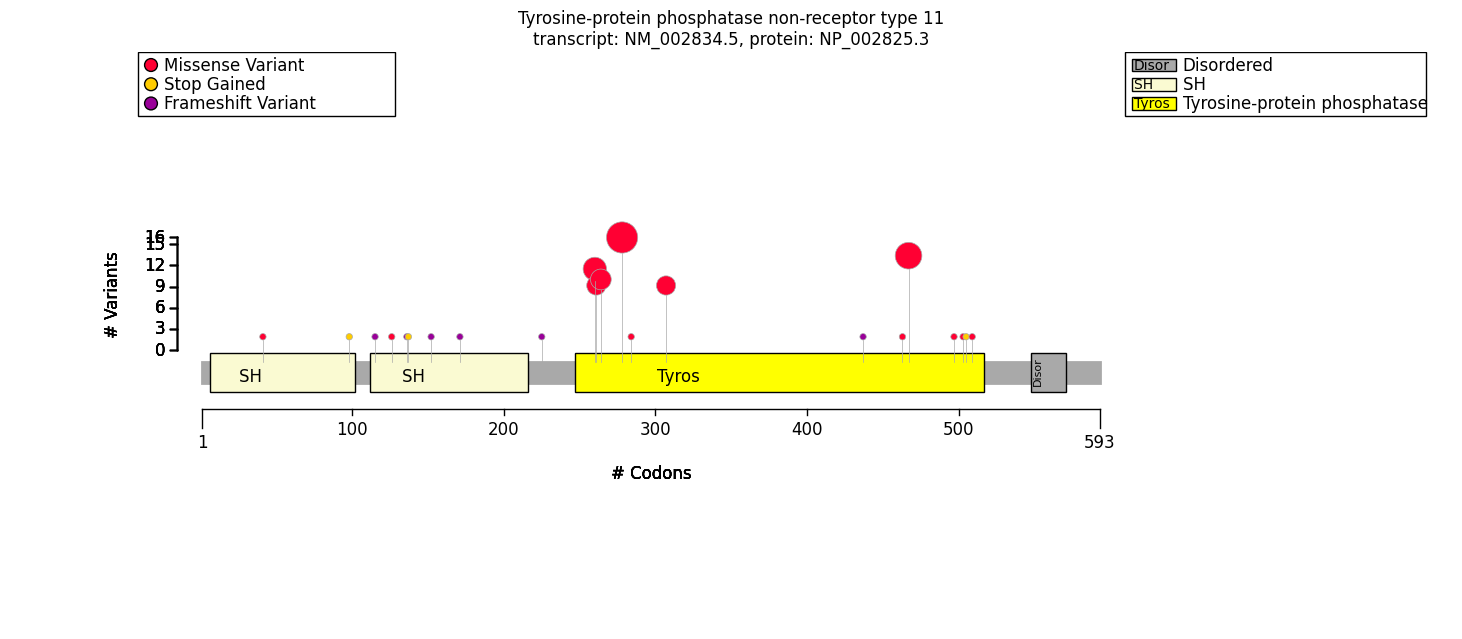

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
ptpn11_fig, ptpn11_ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ptpn11_ax,
)
ptpn11_fig.tight_layout()

In [8]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
SH2 1,DOMAIN,6 - 102,2,p.Lys99Ter; p.Thr42Ala
SH2 2,DOMAIN,112 - 216,6,p.Arg138Ter; p.Val137ArgfsTer17; p.Ile172GlyfsTer13; p.Ser118TrpfsTer10; p.Thr127Ile; p.Thr153LysfsTer8
Tyrosine-protein phosphatase,DOMAIN,247 - 517,58,p.Arg265Gln; p.Met504Val; p.Leu262Phe; p.Leu261Phe; p.Gln506Ter; p.Gln510Glu; p.Leu262Arg; p.Arg498Leu; p.Asn308Asp; p.Gly464Ala; p.Thr468Met; p.Tyr279Cys; p.Leu439TrpfsTer33; p.Leu261His; p.Phe285Leu
Disordered,REGION,548 - 571,0,


# Genotype phenotype correlation analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,10
HMF05,Skipping term because one genotype had zero observations,10
HMF08,Skipping general term,80
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,177


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                   Missense         Other          \
                                  Count Percent Count Percent   
Hypertelorism [HP:0000316]        37/41     90%  0/12      0%   
Webbed neck [HP:0000465]          15/20     75%  0/12      0%   
Pulmonic stenosis [HP:0001642]    18/34     53%  0/12      0%   

Allele group                                                     
                               Corrected p values      p values  
Hypertelorism [HP:0000316]           2.046606e-08  6.822020e-09  
Webbed neck [HP:0000465]             4.413116e-05  2.942077e-05  
Pulmonic stenosis [HP:0001642]       1.230305e-03  1.230305e-03

In [15]:

tyr279cys = VariantPredicates.variant_key("12_112473023_112473023_A_G") # c.836A>G	p.Tyr279Cys
tyr279cys_predicate = missense_predicate = monoallelic_predicate(
    a_predicate=tyr279cys,
    b_predicate=~tyr279cys,
    a_label="Tyr279Cys",
    b_label="Other"
)
tyr279cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=tyr279cys_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=tyr279cys_result)

Allele group                           Tyr279Cys          Other          \
                                           Count Percent  Count Percent   
Webbed neck [HP:0000465]                     0/5      0%  15/27     56%   
Pulmonic stenosis [HP:0001642]               1/9     11%  17/37     46%   
Hypertelorism [HP:0000316]                 14/16     88%  23/37     62%   
Short stature [HP:0004322]                   4/6     67%  22/24     92%   
Multiple lentigines [HP:0001003]           16/16    100%  13/13    100%   
Hypermelanotic macule [HP:0001034]         16/16    100%  15/15    100%   
Abnormal location of ears [HP:0000357]       8/8    100%  20/20    100%   

Allele group                                                         
                                       Corrected p values  p values  
Webbed neck [HP:0000465]                         0.240628  0.045641  
Pulmonic stenosis [HP:0001642]                   0.240628  0.069125  
Hypertelorism [HP:0000316]                       0.240628  0.103126  
Short stature [HP:0004322]                       0.295977  0.169130  
Multiple lentigines [HP:0001003]                 1.000000  1.000000  
Hypermelanotic macule [HP:0001034]               1.000000  1.000000  
Abnormal location of ears [HP:0000357]           1.000000  1.000000

In [16]:
from gpsea.model.genome import Region

tkd_n = VariantPredicates.region(region=Region(247,400), tx_id=mane_tx_id)
tkd_c = VariantPredicates.region(region=Region(401,517), tx_id=mane_tx_id)

tkd_predicate = missense_predicate = monoallelic_predicate(
    a_predicate=tkd_n,
    b_predicate=tkd_c,
    a_label="TK domain N term",
    b_label="TK domain C term"
)
tkd_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=tkd_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=tkd_result)


Allele group                       TK domain N term         TK domain C term  \
                                              Count Percent            Count   
Pulmonic stenosis [HP:0001642]                14/22     64%             4/14   
Hypertelorism [HP:0000316]                    24/26     92%            12/16   
Short stature [HP:0004322]                    20/22     91%              5/6   
Multiple lentigines [HP:0001003]              16/16    100%            13/13   
Hypermelanotic macule [HP:0001034]            17/17    100%            14/14   

Allele group                                                             
                                   Percent Corrected p values  p values  
Pulmonic stenosis [HP:0001642]         29%           0.429011  0.085802  
Hypertelorism [HP:0000316]             75%           0.449554  0.179822  
Short stature [HP:0004322]             83%           0.883191  0.529915  
Multiple lentigines [HP:0001003]      100%           1.000000  1.000000  
Hypermelanotic macule [HP:0001034]    100%           1.000000  1.000000

# Summary

In [17]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=tyr279cys_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=tkd_result
    )
)

caption = "No previous statistical analysis of correlations with PTPN11 missense variants identified in the medical literature."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [18]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [19]:
summarizer.process_latex(report=report, protein_fig=ptpn11_fig)

Figure saved to ../../supplement/img/PTPN11_protein_diagram-draft.pdf
Output to ../../supplement/tex/PTPN11_summary_draft.tex
